#### Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()


# Machine learning with JAX from scratch part II.
Starting out in the field of Machine Learning can be tough. There is so much to learn and when you think you are finally getting a hold of everything that's being said and done, one quick look at the latest research papers of organizations such as Microsoft and Google proves you otherwise. bummer... 

But here is the good news. One thing will never change and if you get that right, you'll set yourself up for success. That one thing we are talking about is becoming an expert in the fundamentals. In this blogpost, I'll help you do just that. Lets get back to the fundamentals, the first principals, the essence. Lets build a simple model together and figure out what's really going on, and for that we'll be leveraging a library referred to as Numpy on steriods: JAX.



## Introducing the problem
You recently joined a Swedish insurance company as a Machine Learning Engineer. They have collected an extremely large datasets of, behold......, 63 rows to predict the total payment for all the claims in thousands of Swedish Kronor for geographical zones in Sweden, and have asked you to build a model for it. In plain English, given the number of claims in a region, predict what the total payment in a region. As such, the dataset we'll work with has only one feature (number of claims) and we'll use that information to train our model to approximate our label (total payment).


## The process (simplified)
It's ease to simplify the process of training a Machine Learning model. One could say that the only ingredients that we need are:
- some training data
- a model
- a loss function

As easy as you like! Or as a gorgeous image (we need more images, don't we?!)

<img src="../assets/images/ml_components_simplified.png" width="300">

Now that we have a good representation of what we'll need, lets put the pieces together. Starting with getting some training data.


## The dataset 

The dataset was already briefly introduced in [Introducing the problem](#introducing-the-problem), but lets verify some of our assumptions.

In [1]:
# Import the necessary packages
from typing import Tuple, List
import requests
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
# You can skip understanding the following code. It's only here to get some data to work with.
def build_auto_insurance_dataset() -> Tuple[List[float], List[float]]:
    url='https://www.math.muni.cz/~kolacek/docs/frvs/M7222/data/AutoInsurSweden.txt'
    raw_dataset = requests.get(url)
    features, labels = [], []
    index_at_which_features_and_labels_start = 11

    raw_data = raw_dataset.text.split("\n")[index_at_which_features_and_labels_start:-1]
    for feature_and_label in raw_data:
        feature_and_label = feature_and_label.split("\t")
        features.append([float(feature_and_label[0].replace(",", "."))])
        labels.append(float(feature_and_label[1].replace(",", ".")))
    return jnp.array(features), jnp.array(labels).reshape(-1, 1)


# some plotting utils to plot our beautiful graphs

def plot_results(features: List[float], labels: List[float], predictions: List[float]):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(features, labels, 'bo', label='Real values')
    ax.plot(features, predictions, 'ro', label='Predicted values')
    ax.plot(features.reshape(-1), predictions.reshape(-1), label='Real values')
    ax.legend(["Actual", "Predicted"])
    ax.set_ylabel("Claims in thousands of Swedish kronor")
    ax.set_xlabel("Number of claims")
    return fig, ax


In [28]:
# features is equal to the total number of claims for a given year
# labels is the total payment for all claims in thousands of Swedish kronor
features, labels = build_auto_insurance_dataset()

# features is a MxN matrix, where M is the number of examples and N is the number of features
# In our case, N is 1, because we have only one feature
# M is the number of examples, which in our case is 63
# As a result our output is a 63x1 matrix
print(f"Our features has shape: {features.shape}")

# whereas our labels is a Mx1 matrix, where M is the number of examples
print(f"Our labels has shape: {labels.shape}")


Our features has shape: (63, 1)
Our labels has shape: (63, 1)


## The model

Now that the dataset is created, which is, according to Donald Trump: Huuuuuggghhhh, we can move forward to building our machine learning model. We'll be building a very simple network (just a linear regression, yay). I'm going to introduce some notations here. Don't worry to much if it looks complex, we'll get there. The model is defined as $f_{w,b}(x_i) = w * x_i + b$, where we have a function $f$ (our model), which has paramaters $w,b$ (often called the weights and bias) which we can train. We can insert an example (formally known as a sample) defined as $x_i$ into this function. The subscript just means it is the ith example. Finally, we specify how the function "operates" by $w * x_i + b$. And that's it. You might need to re-read that sentence a couple of times, but once it clicks, you'll see that the notation is not that awful. One final note, you'll often see $ y^{pred}_i = w * x_i + b$. It's exactly the same. So what we get is:

$$
\begin{align}
forward pass_i = y^{pred}_i \\
y^{pred}_i = f_{w,b}(x_i)  \\
f_{w,b}(x_i) = w * x_i + b \\
\end{align}
$$

And that's what we are going to define with JAX.

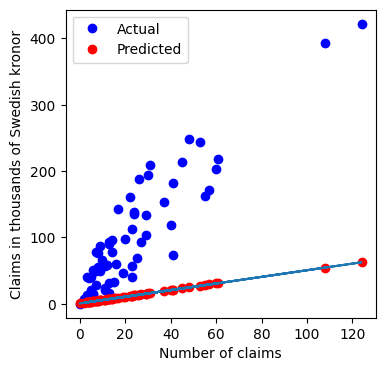

In [29]:
# Introduction to linear regression: f = w * x + b also know as the forward pass.
def forward_pass(feature: jnp.ndarray, weight: jnp.ndarray, bias: jnp.ndarray) -> jnp.ndarray:
    return weight * feature + bias

# We know our model is a Linear Regression model, meaning we have F_w_b(x) = w * x + b where w, b are the model parameters and are a scalar value.
# and x is the model input, which is also a scalar value.
weight = jnp.array([0.5])
bias = jnp.array([0.5]) 
predictions = forward_pass(features, weight, bias)


# Lets plot the results
_ = plot_results(features, labels, predictions)

Great! We were able to use our "model" to make some predictions. However, the results don't look too good, do they?! What is good and what's isn't good anyways? Let's try to make it a bit clearer and for that, we need a cost function. A cost function is telling is you how good or bad your model is (there is a bit more complexity in reality in which your cost could be very low (yeah), but your model still will not work on unseen data (aaargh) (hint: this is called overfitting), but we'll leave that aside for a different time). Now sometimes you'll also hear the term loss function. Most of the time, these are referring to the same thing. However, Andrew Ng normally makes a small distinction which I quite like. He defines a cost function as: a summation over the loss function for all examples. That might still sound complicated, so lets try to make it a bit more formal.

Lets first define the loss function: 
$$
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2
$$

Remember the $y^{pred}_i$? If not, scroll back up and have another look at how we created our predictions.
As briefly mentioned, the loss function determines how far "off" you are from the true value ($y^{true}_i$). The larger the loss is the further away you are from your target.
Now the $y^{true}_i$ is historical data that has already been collected (in our case the claims in thousands of Swedish Kronor)
Our prediction is what we need to compute, which we did during the forward pass. so, we can substitute that in our little formula below.


$$
\begin{align}
forward pass = y^{pred}_i \\
y^{pred}_i = f_{w,b}(x_i)  \\
f_{w,b}(x_i) = w * x_i + b \\
\end{align}
$$
$$
\begin{align}
L(y^{pred}_i, y^{true}_i) = \frac{1}{2} * (y^{pred}_{i} - y^{true}_{i})^2 \\
L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2} * (w * x_i + b - y^{true}_{i})^2 
\end{align}
$$

Alright. So the loss function is defined, but this is only for one sample, label pair (or more simple stated: one training example).
The next part has to do with the cost function often denoted as $J(w, b)$. Again, it's good to become familiar with the notation. $J$ is representating the cost function. Whereas the loss function for a single example was defined as $L$. So what does this mean? It means that for a given weight $w$ and bias $b$, $J$ is the summation over the loss for all training examples.

$$

\frac{1}{m}\sum^{m - 1}_{i=0} * L(f_{w,b}(x_i), y^{true}_i) = \frac{1}{2m}\sum^{m - 1}_{i=0}(f_{w,b}(x_{i}) - y_i)^2
$$

You can also see that happening in this formula, notice how we moved the constant out of the equation (i.e. the $\frac{1}{2}$). In addition that we substitute the quadratic term in the final part of the equation for the $L$.

Pfoeee.... that are quite some lines of mathematical notation. But for now, using the famous words of Andrew Ng, don't worry about it and lets see some actual code.


In [30]:
# remember that the loss is the difference between the predicted value and the actual value
# and is only for a single example
def calculate_loss(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return 1 / 2 * (predictions - labels) ** 2

# calculate the loss for all examples
def calculate_cost(predictions: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean(calculate_loss(predictions, labels))

total_cost = calculate_cost(predictions=predictions, labels=jnp.array(labels))

print(f"The total cost is: {total_cost}")

The total cost is: 6621.8125


## Gradient Descent

With our cost function $J$ defined, we can optimize our machine learning model such that it better "fits" the training data. And in order to do that, we need two components. (1) something that is telling us how good our model is doing, and (2) a way to be update our model to be slightly better next time it makes predictions. The first of ofcourse covered by the cost function, the latter is achieved through gradient descent. I'll not be going into details on how to compute the gradients, but if you are interested in getting a better understanding of gradient descent I'd recommend having a look at Andrej Karpathy's [lecture on backprop](https://www.youtube.com/watch?v=i94OvYb6noo).

For us, it means we need to do two things. We need to compute the gradients (telling us: "Hey! you should move a bit to up to make a better prediction and you should have a slight nudge down next time round") and than we need to use this information and apply it (such that we actually make a better prediction next time round). This is achieved by the `compute_gradients` and `update_weights` functions, respectively. One more thing, if you look in the `update_weights` function, you'll see a learning_rate. The only thing it does it determine how much you would move your parameters (and it is what causes the red dots to move slightly downhill on every iteration in the image)

<img src="../assets/images/ml_components_simplified.png" width="300">

In [38]:
# Gradient descent
# Taking the derivate of the cost function with respect to the weight and bias.
def compute_gradient(features, weight, bias, labels):
    predictions = forward_pass(features, weight, bias)

    weight_derivative = jnp.mean(((predictions - labels) * features))  
    bias_derivative = jnp.mean((predictions - labels) * 1)
    return weight_derivative, bias_derivative

# update weights and bias using the gradient descent algorithm.
def update_weights(features, weight, bias, labels, learning_rate):
    weight_derivative, bias_derivative = compute_gradient(features, weight, bias, labels)
    weight = weight - learning_rate * weight_derivative
    bias = bias - learning_rate * bias_derivative
    return weight, bias


## Training our model. Finally :)

After gathering all the required building blocks, we are finally ready to merge them together and create our training recipe.
The steps we need to take are as follows:
1. initialize weight and bias (we can just assign random weights. During the optimization these parameters will almost magically get updated to the 'correct' values).
2. for epoch in 0...n_epochs: # this is saying, do the following n_epochs times
    - 2a. forwardpass (remember, these are our initial predictions, which will get better over time)
    - 2b. calculate cost (This provides us and the model with some information about how good it is performing)
    - 2c update weights (aah ofcourse, the backprop thingy... I know, I know. updating the weights to be slightly better next time round)


In [39]:

# 1. init weights
weight = 0
bias = 0

# 2. for i in ...epochs
n_epochs = 50
learning_rate = 0.0001
costs = []
for epoch in range(n_epochs):

    # 2a forward pass
    predictions = forward_pass(features, weight, bias)
    # 2b cost calculation
    cost = calculate_cost(predictions, labels)
    
    # 2c update weights and bias
    weight, bias = update_weights(features, weight, bias, labels, learning_rate)
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} Cost: {cost}")
    costs.append(cost)

Epoch: 0 Cost: 8572.8994140625
Epoch: 5 Cost: 3279.61376953125
Epoch: 10 Cost: 1556.776611328125
Epoch: 15 Cost: 996.0112915039062
Epoch: 20 Cost: 813.4652709960938
Epoch: 25 Cost: 754.0179443359375
Epoch: 30 Cost: 734.6356811523438
Epoch: 35 Cost: 728.2932739257812
Epoch: 40 Cost: 726.1950073242188
Epoch: 45 Cost: 725.4780883789062


Pretty cool. Looking at the output, we see that the cost function is decreasing. Which is telling us that our model is becoming better every step it takes! Again, we're not covering overfitting in this blogpost, so you can leave that aside for now. Plotting the costs versus the number of epochs confirms our observation. Our model is learning (hopefully, so are you:)). 

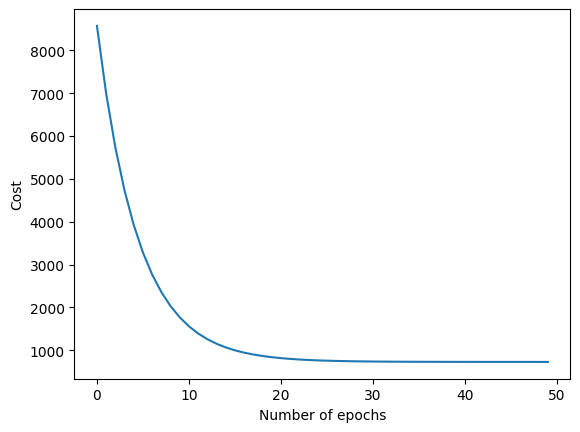

In [42]:
plt.plot(costs)
plt.ylabel("Cost")
plt.xlabel("Number of epochs")
plt.show()

So how did this impact the ability of our model to make predictions and solve the problem explained in the opening of this blogpost? Well, we definetely made a lot of progress. Plotting our results, but now with the trained parameters (i.e. not the random parameters we started with, but the once we obtained through training), shows that we are able to fit a nice straight line directly through the training examples. Our model just learned to make pretty accurate predictions, isn't that cool?!!

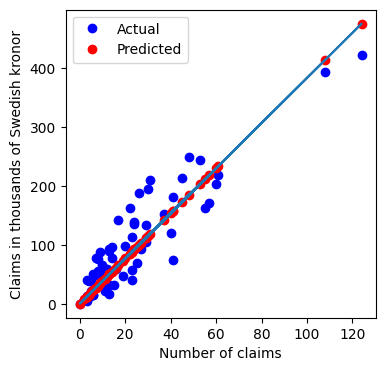

In [43]:
fig, ax = plot_results(
    features,
    labels,
    forward_pass(features, weight, bias)
)

And we ofcourse can use it to make new predictions :)

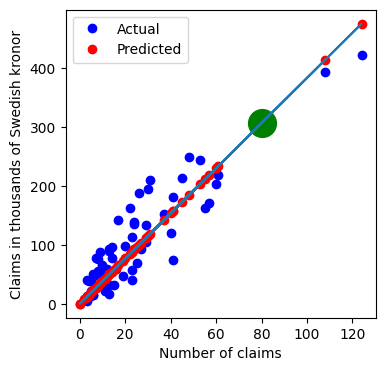

In [44]:
new_number_of_claims = jnp.array([80])
prediction = forward_pass(new_number_of_claims, weight, bias)
ax.scatter(new_number_of_claims, prediction, s=400, c='g')
fig

# Are we there yet?
That was quite the ride. We build a model, got a better understanding of a loss/cost function (do you recall the differce?), implemented gradient descent and finally made a prediction with our freshly trained model. The business is happy with the results you delivered and even awarded you with a medal. You are now the company's ML engineer of the Year (I bet they didn't tell you that you were also the only ML engineer at the company, or did they?). Anyways, the have grown confident that you are not just the next one. They feel like they just hired there personal [Moneyball](https://en.wikipedia.org/wiki/Moneyball_(film)) and expect even more. Are you up for the challenge? Are you ready to take your ML and JAX skills to the next level? Checkout part II of the series [Machine learning with JAX from scratch part III.](). Finally, feel free to decide for yourself if you want to, but if you liked this blogpost (or the series in general), I'd greatly appreciate if you would like it on Medium and/or GitHub to help others more easily find this content as well.

## Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()
